# Merge all datasets

## Imports and defs

In [1]:
import pandas as pd

years_list = [2020, 2021, 2022]  # List of years for which datasets need to be loaded

dataset_info = {
    'level': {'directory': 'level', 'colname': 'LEVEL'},
    'pressure': {'directory': 'pressure', 'colname': 'PRESS'},
    'rain': {'directory': 'rain', 'colname': 'RAIN'},
    'temperature': {'directory': 'temperature', 'colname': 'TEMP'},
    'wind_dir': {'directory': 'wind_dir', 'colname': 'WDIR'},
    'wind_speed': {'directory': 'wind_speed', 'colname': 'WSPEED'}
}


## Load data

### Helper load data function

In [2]:
def load_datasets(_directory, _years, _col_name):
    """
    Load datasets from multiple years located in different directories.

    Parameters:
    - directory (str): The base directory where the data is located.
    - years (list): A list of years for which datasets need to be loaded.
    - colname (str): The column name for the data read.

    Returns:
    - df_concatenated (pandas DataFrame): Concatenated DataFrame containing data from all years.
    """
    dfs = []  # List to store DataFrames from each year
    
    # Iterate over each year and load the corresponding dataset
    for year in _years:
        file_path = f"{_directory}/{year}.txt"
        try:
            df = pd.read_csv(file_path, sep=';', names=['DATE', 'DUMMY1', _col_name, 'DUMMY2'])
            # Drop unnecessary columns
            df.drop(columns=['DUMMY1', 'DUMMY2'], inplace=True)
            # Convert DATE column to datetime
            df['DATE'] = pd.to_datetime(df['DATE'])
            dfs.append(df)
        except FileNotFoundError:
            print(f"File {file_path} not found. Skipping...")
    
    # Concatenate DataFrames from all years
    df_concatenated = pd.concat(dfs)
    
    return df_concatenated

### Load and join

In [3]:
# load all datasets
datasets = {}

for dataset_type, info in dataset_info.items():
    directory = info['directory']
    col_name = info['colname']
    datasets[dataset_type] = load_datasets(directory, years_list, col_name)

# Merge datasets on the 'DATE' key
df_venice = datasets['level']  # Start with the first dataset

# Merge each dataset on the 'DATE' key
for dataset_type, df in datasets.items():
    if dataset_type != 'level':  # Skip merging with itself
        df_venice = pd.merge(df_venice, df, how='outer', on='DATE')

# Sort the DataFrame by date
df_venice.sort_values(by='DATE', inplace=True)

# Reset index
df_venice.reset_index(drop=True, inplace=True)

# Display the merged DataFrame
print(df_venice.head())
print(df_venice.dtypes)

                 DATE  LEVEL   PRESS  RAIN  TEMP   WDIR  WSPEED
0 2020-01-01 00:00:00   28.0  1030.8   0.0   6.6  308.0     3.2
1 2020-01-01 00:05:00   29.0  1030.8   0.0   6.7  315.0     3.4
2 2020-01-01 00:10:00   30.0  1030.9   0.0   6.7  322.0     3.3
3 2020-01-01 00:15:00   30.0  1030.9   0.0   6.7  324.0     3.5
4 2020-01-01 00:20:00   30.0  1030.9   0.0   6.5  319.0     3.4
DATE      datetime64[ns]
LEVEL            float64
PRESS            float64
RAIN             float64
TEMP             float64
WDIR             float64
WSPEED           float64
dtype: object


## Verify and Plot Data

In [4]:
# modified fromm the one found here: https://stackoverflow.com/questions/37366717/pandas-print-column-name-with-missing-values
def missing_zero_values_table(_df):
        zero_val = (_df == 0.00).astype(int).sum(axis=0)
        mis_val = _df.isnull().sum()
        zero_val_percent = 100 * zero_val / len(_df) 
        mis_val_percent = 100 * mis_val / len(_df)
        mz_table = pd.concat([zero_val, zero_val_percent, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : '% of Zero Values', 2 : 'Missing Values', 3 : '% of Total Values'})
        mz_table['Zero + Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Zero + Missing Values'] = 100 * mz_table['Zero + Missing Values'] / len(_df)
        mz_table['Data Type'] = _df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

venice_plot = df_venice.plot.area(x="DATE", figsize=(12,16),stacked=False,subplots=True)
missing_zero_values_table(df_venice)



Your selected dataframe has 2 columns and 312735 Rows.
There are 5 columns that have missing values.


,Zero Values,% of Zero Values,Missing Values,% of Total Values,Zero + Missing Values,% Zero + Missing Values,Data Type
TEMP,5,0.0,31965,10.1,31970,10.1,float64
WSPEED,2,0.0,2911,0.9,2913,0.9,float64
WDIR,856,0.3,2650,0.8,3506,1.1,float64
RAIN,310055,98.2,1651,0.5,311706,98.8,float64
LEVEL,2224,0.7,174,0.1,2398,0.8,float64


## Fill in missing temperature data

Your selected dataframe has 2 columns and 312735 Rows.
There are 5 columns that have missing values.


,Zero Values,% of Zero Values,Missing Values,% of Total Values,Zero + Missing Values,% Zero + Missing Values,Data Type
WSPEED,2,0.0,2911,0.9,2913,0.9,float64
WDIR,856,0.3,2650,0.8,3506,1.1,float64
RAIN,310055,98.2,1651,0.5,311706,98.8,float64
LEVEL,2224,0.7,174,0.1,2398,0.8,float64
TEMP,5,0.0,122,0.0,127,0.0,float64


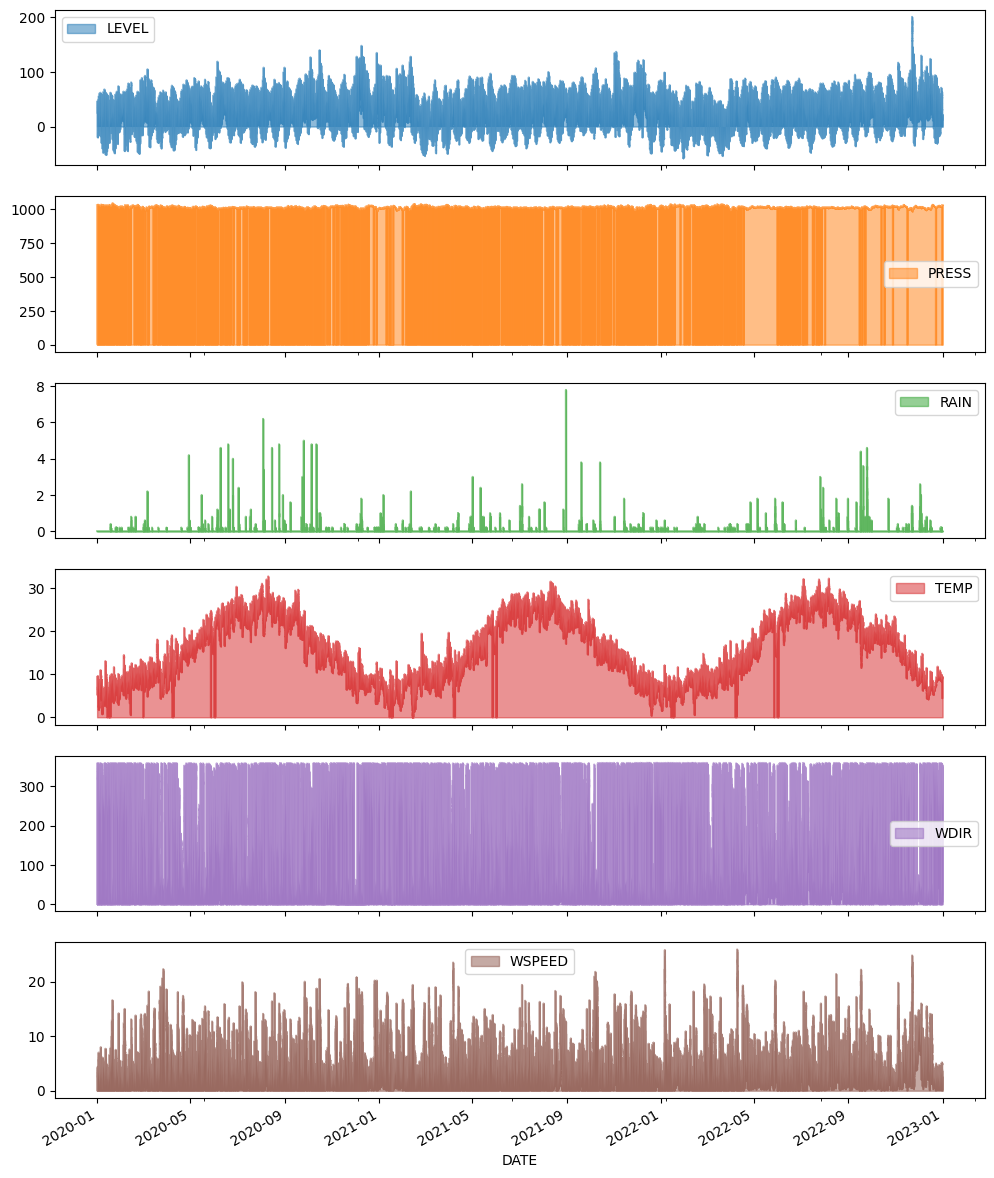

In [ ]:
def fill_missing_temperature(_df):
    """
    Fill missing values for the TEMP column based on the mean temperature values within a specified period.

    Parameters:
    - _df (pandas DataFrame): The DataFrame containing the temperature data.
    
    Returns:
    - df_filled (pandas DataFrame): DataFrame with missing values filled in for the TEMP column.
    """
    # Extract month, day, hour, and minute from the DATE column
    _df['MONTH'] = _df['DATE'].dt.month
    _df['DAY'] = _df['DATE'].dt.day
    _df['HOUR'] = _df['DATE'].dt.hour
    _df['MINUTE'] = _df['DATE'].dt.minute
    
    # Group DataFrame by date and calculate mean TEMP
    grouped = _df.groupby(['MONTH', 'DAY', 'HOUR', 'MINUTE'])['TEMP'].mean().reset_index()
    grouped['TEMP'] = grouped['TEMP'].round(1)

    # Merge mean TEMP values back to the original DataFrame and fill missing TEMP values
    df_filled = _df.merge(grouped, on=['MONTH', 'DAY', 'HOUR', 'MINUTE'], how='left', suffixes=('', '_MEAN'))
    df_filled['TEMP'] = df_filled['TEMP'].fillna(df_filled['TEMP_MEAN'])

    # Drop redundant columns
    df_filled.drop(columns=['MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMP_MEAN'], inplace=True)

    return df_filled

# Create a copy of the DataFrame to avoid modifying the original
df_venice = fill_missing_temperature(df_venice)

venice_plot = df_venice.plot.area(x="DATE", figsize=(12,16),stacked=False,subplots=True)
missing_zero_values_table(df_venice)

## Create Files

In [ ]:
#df_venice_small = df_venice[(df_venice["DATE"].dt.minute == 0) | (df_venice["DATE"].dt.minute == 30)]
df_venice_small = df_venice[(df_venice["DATE"].dt.minute == 0)]

df_venice_small.reset_index(drop=True, inplace=True)

df_venice.to_csv('venice.csv')
df_venice_small.to_csv('venice_small.csv')